# Exercise 11

Exercise 11. Train and fine-tune an SVM regressor on the California housing dataset. You can use the
original dataset rather than the tweaked version we used in Chapter 2, which you can load using `sklearn.datasets.fetch_california_housing()`.
The targets represent hundreds of thousands of dollars. Since there are over 20000 instances, SVMs can
be slow, so for hyperparameters tuning you should use far fewer instances (e.g. 2000) to test many more
hyperparameter combinations. What is your best model's RMSE?

In [4]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)

In [5]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
import pandas as pd

housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df["median_house_value"] = housing.target

In [7]:
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20640 non-null  float64
 1   HouseAge            20640 non-null  float64
 2   AveRooms            20640 non-null  float64
 3   AveBedrms           20640 non-null  float64
 4   Population          20640 non-null  float64
 5   AveOccup            20640 non-null  float64
 6   Latitude            20640 non-null  float64
 7   Longitude           20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [9]:
housing["target_names"]

['MedHouseVal']

## Explore and visualize data

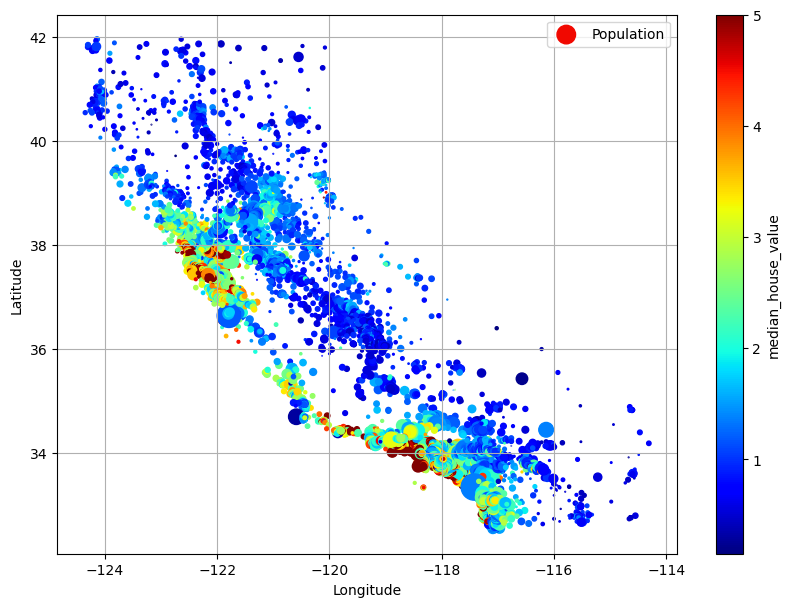

In [22]:
import matplotlib.pyplot as plt

housing_df.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, s=housing_df["Population"] / 100, label="Population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False,figsize=(10,7))
plt.show()

### Split data into training and test sets

In [10]:
from sklearn.model_selection import train_test_split

X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Rough SVR approach

This is the first approach we undertake before any feature engineering.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np

# Create a training subset (2000 samples as suggested
X_subset = X_train[:2000]
y_subset = y_train[:2000]

# Create a base pipeline (try to improve later)
svm_base_pipeline = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf')
)

scores = cross_val_score(svm_base_pipeline,
                         X_subset,
                         y_subset,
                         scoring='neg_root_mean_squared_error',
                         cv=5
                        )
rmse_scores = -scores
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std() * 2:.3f})")

RMSE scores: [0.56652509 0.53635306 0.60890389 0.53755847 0.60375024]
Mean RMSE: 0.571 (+/- 0.062)


### Tuning the SVM parameters

Before jumping into feature engineering, one more thing that we could try out is tuning
hyperparameters. We will be playing with the following SVM hyperparameters:
- `C` regularization parameter: how much do we care about mistakes in training data
- `gamma` (RBF kernel parameter): how far should the influence of each training example reach
- `epsilon` (margin of tolerance):how much error are we willing to ignore

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# unlike randint, reciprocal prefers samples in lower ranges to those in higher ranges
# this could be particularly useful for hyperparameters of our choice
param_distributions = {
    'svr__C': reciprocal(0.1, 100),
    'svr__gamma': reciprocal(1e-3, 1),
    'svr__epsilon': reciprocal(0.01, 1)
}

random_search = RandomizedSearchCV(
    svm_base_pipeline,
    param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42
)
random_search.fit(X_subset, y_subset)
random_search.best_params_

{'svr__C': 1.976218934028007,
 'svr__epsilon': 0.038234752246751866,
 'svr__gamma': 0.06847920095574778}

#### Optimized SVR model

Retun the defined above model with the hyperparameter values from our randomized search

In [35]:
# create optimized pipeline with best parameters
svm_optimized_pipeline = make_pipeline(
    StandardScaler(),
    SVR(
        kernel='rbf',
        C=1.9762,
        epsilon=0.0382,
        gamma=0.0685,
    )
)

# train on full training set
svm_optimized_pipeline.fit(X_train, y_train)

# cross-validate to see improvement
optimized_scores = cross_val_score(
    svm_optimized_pipeline,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=5
)

rmse_scores = -optimized_scores
print("Optimized model performance: ")
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std() * 2:.3f})")

Optimized model performance: 
RMSE scores: [0.60674281 0.60032889 0.6003318  0.58959151 0.61989526]
Mean RMSE: 0.603 (+/- 0.020)


## Feature Engineering


Next we are adding a few new features:

1. Base feature combinations
2. Income buckets (instead of having a long tail, have a few buckets which would comprise all values)
3. Add `OceanProximity` feature to transform Longitude and Lattitude into an enum like data
4. Potentially drop some of the original (or later) to avoid overfitting.

In [45]:
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")

X_train type: <class 'pandas.core.frame.DataFrame'>
X_train shape: (16512, 8)


In [16]:
# feature combinations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureCombinationsEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer for combined features"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X['AveRooms'] / X['AveOccup']
        bedrooms_per_room = X['AveBedrms'] / X['AveRooms']
        population_per_household = X['Population'] / X['AveOccup']
        return np.c_[
            rooms_per_household, 
            bedrooms_per_room, 
            population_per_household
        ]

    def get_feature_names_out(self, feature_names=None):
        return ['rooms_per_household', 
                'bedrooms_per_room', 
                'population_per_household'
               ]

<Axes: xlabel='MedInc'>

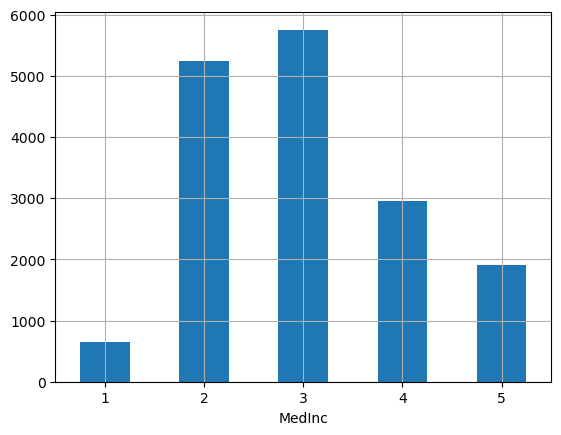

In [14]:
income_cat = pd.cut(X_train['MedInc'], bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True)

In [15]:
# income buckets
class IncomeCategoriesFeatureEngineer(BaseEstimator, TransformerMixin):
    """Transformer for creating income buckets"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        income_cat = pd.cut(X['MedInc'],
                            bins=[0.,1.5,3.0,4.5,6.,np.inf],
                            labels=[1,2,3,4,5])
        return income_cat.values.reshape(-1, 1) # transform 1D array to 2D array

    def get_feature_names_out(self, feature_names=None):
        return ['income_category']
        

In [22]:
class OceanProximityEngineer(BaseEstimator, TransformerMixin):
    """Transformer for creating ocean proximity categories"""
    # California coast reference points
    CENTRAL_COAST_LAT = 36.0 # Central California latitude
    CENTRAL_COAST_LONG = -122.0 # Average coastal longitude

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lat = X['Latitude']
        long = X['Longitude']

        # Calculate rough distance from coast
        # Positive values = inland, Negative values = coastal
        coastal_distance = (lat - self.CENTRAL_COAST_LAT) - (long - self.CENTRAL_COAST_LONG) / 2

        ocean_cat = pd.cut(coastal_distance,
            bins=[-np.inf, -0.5, 0.5, np.inf],
            labels=[1, 2, 3]) # 1=coastal, 2=intermediate, 3=inland
        return ocean_cat.values.reshape(-1, 1)

    def get_feature_names_out(self, feature_names=None):
        return ['ocean_proximity']

In [23]:
def create_preprocessor():
    return ColumnTransformer(
        transformers=[
            # Keep original features
            ('original', StandardScaler(), ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                'Population', 'AveOccup', 'Latitude', 'Longitude']),
            # Add engineered features
            ('combinations', Pipeline([
                ('combinations', FeatureCombinationsEngineer()),
                ('scaler', StandardScaler())
            ]), ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']),
            # Add income buckets
            ('income_categories', IncomeCategoriesFeatureEngineer(),['MedInc']),
            ('ocean_proximity', OceanProximityEngineer(), ['Latitude', 'Longitude'])
        ],
        verbose_feature_names_out=False)

# create full pipeline
def create_pipeline():
    return Pipeline([
        ('preprocessor', create_preprocessor()),
        ('svr', SVR(kernel='rbf', C=1.9762, epsilon=0.0382, gamma=0.0685))
    ])

In [24]:
feature_engineered_pipeline = create_pipeline()

# cross-validate
scores = cross_val_score(
    feature_engineered_pipeline,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=5
)

# print results
rmse_scores = -scores
print("\nBaseline stuctured pipeline performance:")
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std() * 2:.3f})")


Baseline stuctured pipeline performance:
RMSE scores: [0.56654598 0.5474754  0.55530035 0.53873145 0.57538385]
Mean RMSE: 0.557 (+/- 0.026)


## Check the model for overfittting

This step could show us whether there is a significant gap between training and validation performance. A large gap would indicate overfitting.

In [26]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    feature_engineered_pipeline,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=5,
    return_train_score=True
)
Feature
print("\nModel Performance:")
print(f"Training RMSE: {-cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
print(f"Validation RMSE: {-cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")


Model Performance:
Training RMSE: 0.537 (+/- 0.006)
Validation RMSE: 0.557 (+/- 0.026)


The gap between training and validation performance is relatively small, which indicates we're not
severly overfitting:
1. *Healthy Model Balance*: The small difference suggests our model is generalizing fairly well to unseen data. SVMs with proper regularization tend to avoid severe overfitting
2. *Reasonable Variance*: Validation RMSE has higher variance (0.026) than training (0.006), which is normal - the model's performance fluctuates more on unseen data
3. *Improvement potential*: We've made modest progress with feature engineering:
    1. Started at RMSE 0.603
    2. Now at RMSE 0.557 (about 7.6% improvement)
  
Next steps could be made further to improve the result. We would be considering steps for building-up on what we've achieved thus far, plus a few of the improvements that we could lend from the Chapter's 2 walk through project:
1. *Log Transformations for Skewed Features*: Apply `np.log` to `AveRooms`, `AveBdrooms` and `Population`. This is particularly promissing for improving SVM's performance
2. *Enhanced Geographic Features*:
    1. Improve the ocean proximity feature with more precise distance metrics
    2. Consider distance from major cities: LA, SF, San-Diego
    3. Implementation complexity: Medium, high impact potential
3. *Hyperparameter Retuning*: Our feature set has changed since previous tuning attempt, hence the optimal `C`, `gamma` and `epsilon` values might be diffferent.
4. *Feature Selection*: We could try removing some origiinal features that might be redundant after adding engineered ones (like removing `Latitude` and `Longitude` since we have `ocean_proximity` now)
5. *Kernel Exploration*: Test other SVM kernels: `LinearSVR`, polynomial kernel with various degrees
6. *Outlier Handling*: Apply `IsolationForrest` to identify and remove outliers, or use SVM's built-in outlier handling by adjusting `C` parameter


## New Improvements

### Adding `log_transform` to `AveRooms`, `AveBedrms` and `Population`

This is added directly to the updated `create_preprocessor` method below:
- Adding log-transformed versions of `AveRooms`, `AveBdrms`, and `Population`
- Keeping the raw versions for use in the combiantion transformers
- Omitting the raw versions from the 'original' transformer

In [73]:
# enhanced geographic features instead of the former OceanProximityEngineer
class EnhancedGeographicFeatures(BaseEstimator, TransformerMixin):
    """Creates distance-based geographic features"""
    # Major California city coordinates
    SF_COORDS = (37.77, -122.42) # San Francisco
    SJ_COORDS = (37.34, -121.89) # San Jose
    LA_COORDS = (34.05, -118.24) # Los Angeles
    SD_COORDS = (32.772, -117.16) # San Diego
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lat = X['Latitude']
        long = X['Longitude']

        # Calculate distances to major cities
        sf_distance = np.sqrt((lat  - self.SF_COORDS[0])**2 + (long - self.SF_COORDS[1])**2)
        sj_distance = np.sqrt((lat  - self.SJ_COORDS[0])**2 + (long - self.SJ_COORDS[1])**2)
        la_distance = np.sqrt((lat  - self.LA_COORDS[0])**2 + (long - self.LA_COORDS[1])**2)
        sd_distance = np.sqrt((lat  - self.SD_COORDS[0])**2 + (long - self.SD_COORDS[1])**2)

        # Calculate minimum distance to any major city
        min_distance = np.minimum(np.minimum(np.minimum(sf_distance, sj_distance), la_distance), sd_distance)

        # Calculate coastal proximmity
        coastal_distance = (lat - 36) - (long + 122) / 2

        return np.c_[sf_distance, sj_distance, la_distance, sd_distance, min_distance, coastal_distance]

    def get_feature_names_out(self, feature_names=None):
        return ['sf_distance', 'sj_distance', 'la_distance', 'sd_distance', 'min_city_distance', 'coastal_distance']

In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

def create_preprocessor_new():
    return ColumnTransformer(
        transformers=[
            # Apply log transformations to skewed features
            ('log_transform', make_pipeline(
                SimpleImputer(strategy="median"),
                FunctionTransformer(np.log, feature_names_out="one-to-one"),
                StandardScaler()
            ), ['AveRooms', 'AveBedrms', 'Population']),
            # Keep original features
            ('original', StandardScaler(), ['MedInc', 'HouseAge', 'AveOccup']),
            # Add engineered features
            ('combinations', Pipeline([
                ('combinations', FeatureCombinationsEngineer()),
                ('scaler', StandardScaler())
            ]), ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']),
            # Add income buckets
            ('income_categories', IncomeCategoriesFeatureEngineer(),['MedInc']),
            ('ocean_proximity', EnhancedGeographicFeatures(), ['Latitude', 'Longitude'])
        ], verbose_feature_names_out=False
    )

### Recalculate hyperparameters

Since we've made substantial changes to our feature set, the optimal hypperparameters are likely
different now:

In [77]:
# Create the full pipeline
full_pipeline = Pipeline([
    ('preprocessor', create_preprocessor_new()),
    ('svr', SVR(kernel='rbf'))
])

# Define wider parameter distributions
param_distribs = {
    'svr__C': reciprocal(0.1, 1000), # Wider range than before
    'svr__gamma': reciprocal(1e-4, 1), # Try lower values too
    'svr__epsilon': reciprocal(0.01, 1) # More fine-grained
}

# Run a more extensive search
rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=20, # Try more combinations
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

# Commenting this out as it runs for hours
rnd_search.fit(X_subset, y_subset)

# Get the best parameters
print("Best parameters:", rnd_search.best_params_)
print("Best RMSE:", -rnd_search.best_score_)

Best parameters: {'svr__C': 44.67752817973903, 'svr__epsilon': 0.0420167205437253, 'svr__gamma': 0.012030178871154668}
Best RMSE: 0.562840751307298


### Try different kernels

We will try two different SVM kernel types to try and see if they could give us performance improvement:

- `linear`
- `poly`

So far we've tried `rbf` only.

In [65]:
# Create a linear SVM pipeline
linear_pipeline = Pipeline([
    ('preprocessor', create_preprocessor_new()),
    ('svr', SVR(kernel='linear', C=1.0)) # use default C for now
])

linear_scores = cross_val_score(
    linear_pipeline, X_train, y_train,
    scoring='neg_root_mean_squared_error', cv=5
)
print(f"Linear kernel RMSE: {-linear_scores.mean():.3f} (+/- {linear_scores.std() * 2:.3f})")

Linear kernel RMSE: 0.737 (+/- 0.055)


In [66]:
# Create a polynomial kernel pipeline
poly_pipeline = Pipeline([
    ('preprocessor', create_preprocessor_new()),
    ('svr', SVR(kernel='poly', degree=2, C=1.0, gamma='scale'))
])

poly_scores = cross_val_score(
    poly_pipeline, X_train, y_train,
    scoring='neg_root_mean_squared_error', cv=5
)

print(f"Poly kernel RMSE: {-poly_scores.mean():.3f} (+/- {poly_scores.std() * 2:.3f})")

Poly kernel RMSE: 0.788 (+/- 0.634)


Both alternative kernels showed results that are too far off to even consider fine tuning them.

In [74]:
# create full pipeline
def create_pipeline_new():
    return Pipeline([
        ('preprocessor', create_preprocessor_new()),
        ('svr', SVR(kernel='rbf', C=1.6537, epsilon=0.0157, gamma=0.0546))
    ])

### Find and handle potential outliers

We are using `IsolationForrest` to detect data instance outliers. This algorithm identifies samples that appear to be significantly diffferent from the majority of data points. It works by:
- building rnadom decision trees
- isolating outliers by requiring fewer random partitions
- the intuition is that anomalous points are easier to "isolate" than normal points

The `contamination` parameter represents an estimate of what percentage of the data consists of outliers. 5% is common starting value. Visualizing the ddata and using techniques like boxplots to identify outliers, cross-validating different contamination levels could be systematic approaches for finding the right `contamination` level.

In [76]:
from sklearn.ensemble import IsolationForest

# Identify outliers
iso_forest = IsolationForest(random_state=42, contamination=0.05) # assume 5% outliers
outlier_pred = iso_forest.fit_predict(X_train)

## Keep only non-outlier data
X_train_no_outliers = X_train[outlier_pred == 1]
y_train_no_outliers = y_train[outlier_pred == 1]

print(f"original data: {X_train.shape[0]} samples")
print(f"After outlier removal: {X_train_no_outliers.shape[0]} samples")

# Test performance without outliers
improved_pipeline = create_pipeline_new()
outlier_scores = cross_val_score(
    improved_pipeline,
    X_train_no_outliers,
    y_train_no_outliers,
    scoring='neg_root_mean_squared_error',
    cv=5
)
print(f"No outliers RMSE: {-outlier_scores.mean():.3f} (+/- {outlier_scores.std() * 2:.3f})")

original data: 16512 samples
After outlier removal: 15686 samples
No outliers RMSE: 0.524 (+/- 0.018)


In [75]:
from datetime import datetime

improved_pipeline = create_pipeline_new()

# cross-validate
scores = cross_val_score(
    improved_pipeline,
    X_train_no_outliers,
    y_train_no_outliers,
    scoring='neg_root_mean_squared_error',
    cv=5
)

# print results
rmse_scores = -scores
print("\nBaseline stuctured pipeline performance:")
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std() * 2:.3f})")
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


Baseline stuctured pipeline performance:
RMSE scores: [0.53599166 0.51728913 0.52717449 0.51090787 0.52933284]
Mean RMSE: 0.524 (+/- 0.018)
2025-02-25 22:21:56
